# ***Imports***

In [1]:
!python --version

Python 3.8.4rc1


In [2]:
!pip install tiktoken
!pip install keras-nlp --upgrade

     -------------------------------------- 635.3/635.3 kB 1.5 MB/s eta 0:00:00
     ---------------------------------------- 62.6/62.6 kB 3.5 MB/s eta 0:00:00
     ---------------------------------------- 96.4/96.4 kB 1.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.24.0
    Uninstalling requests-2.24.0:
      Successfully uninstalled requests-2.24.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.2.0 requires click<8.0,>=7.0, but you have click 8.1.3 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


     -------------------------------------- 527.7/527.7 kB 1.6 MB/s eta 0:00:00
  Using cached tensorflow_text-2.10.0-cp38-cp38-win_amd64.whl (5.0 MB)
     -------------------------------------- 455.9/455.9 MB 1.3 MB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 1.8 MB/s eta 0:00:00
     -------------------------------------- 126.5/126.5 kB 1.8 MB/s eta 0:00:00
     -------------------------------------- 438.7/438.7 kB 1.8 MB/s eta 0:00:00
     ---------------------------------------- 5.9/5.9 MB 1.5 MB/s eta 0:00:00
     ---------------------------------------- 24.4/24.4 MB 1.7 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 1.7 MB/s eta 0:00:00
  Attempting uninstall: libclang
    Found existing installation: libclang 12.0.0
    Uninstalling libclang-12.0.0:
      Successfully uninstalled libclang-12.0.0
  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstal

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflowjs 3.17.0 requires packaging~=20.9, but you have packaging 21.3 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tiktoken
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import Progbar,pad_sequences
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import LearningRateSchedule

from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import layers,Model,Sequential,Input
from keras_nlp.layers import SinePositionEncoding
from sklearn.model_selection import train_test_split
# import lxml.etree as ET
from tensorflow.keras.models import load_model

# ***Utils***

In [2]:
RAP = True
SEED = 42
BATCH_SIZE = 512
FRENCH = True
BLOCK_SIZE = 8

# ***Dataset***

In [5]:
if FRENCH : 
    file_path = '/kaggle/input/french-reddit-discussion/final_SPF_2.xml'
    #Initializes the parser
    parser = ET.XMLParser(recover=True)
    #Parses the file
    tree = ET.parse(file_path, parser=parser)
    xroot = tree.getroot()

    #One conversation -> one line in the data array
    dfcols = ['link_id', 'subreddit_id', 'uid',"comment_id",'score', 'parent_id', 'create_utc', 'text']
    data=np.array(([[ [node.attrib.get('link_id'),node.attrib.get('subreddit_id'), node.getchildren()[j].get('uid'), node.getchildren()[j].get('comment_id'), node.getchildren()[j].get('score'), node.getchildren()[j].get('parent_id'), node.getchildren()[j].get('create_utc'),node.getchildren()[j].text] for j in range(len(node.getchildren()))] for node in xroot]), dtype=object)
    print('number of conversations: ',data.shape[0])

    #one comments -> one line in the data array
    data=np.array([liste for conversation in data for liste in conversation], dtype=object)
    print('number of comments: ',data.shape[0])

number of conversations:  556622
number of comments:  1583083


In [6]:
FACTEUR = 0.5

if FRENCH : 
    MAX_DATA = int(data.shape[0]*FACTEUR)
    db_french = pd.DataFrame(data=data, columns=dfcols)
    X = db_french["text"][:MAX_DATA]
    X = np.array(X.values)
    for i,string in enumerate(X):
        X[i] = string.replace('\n', '<nl>') 
elif not RAP: 
    db_balanced = pd.read_csv("/kaggle/input/sarcasm/train-balanced-sarcasm.csv")
    X = "<User> : " + db_balanced["parent_comment"] + "<nl><AI> : " + db_balanced["comment"]
    X = np.array(X.values)
    MAX_DATA = int(X.shape[0]*FACTEUR)
    X = X[:MAX_DATA]
else :
    lyrics_file = glob.glob("/kaggle/input/french-rap-lyrics/french_rap_lyrics/*")
    X = ""
    for file in lyrics_file : 
        with open(file,"r",encoding="utf-8") as f :
            X += f.read()
            
len(X)

(633233,)

In [7]:
if not RAP : 
    X_train,X_test = train_test_split(X,test_size=0.1,random_state=SEED)

# ***Tokenizer***

In [3]:
# tokenizer = tiktoken.get_encoding('gpt2') # in a local device

In [9]:
def convert_to_dataset(data):
    data = tf.convert_to_tensor(data)
    data = tf.data.Dataset.from_tensor_slices(data)
    data = data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return data

def get_chunks(data,block_size=8):
    targets = []
    values = []
    for i,tokens in enumerate(data) :
        if len(tokens)>(2*block_size)+1:
            upper_bound = len(tokens)-block_size
            nb = np.random.randint(upper_bound)
            values.append(tokens[nb:nb+block_size])
            targets.append(tokens[nb+1:nb+block_size+1])

    values = np.vstack(values)
    targets = np.vstack(targets)
    
    return values,targets

def encode_text(X,tokenizer):
    X = np.array([tokenizer.encode(str(value)) for value in X],dtype=object)
    X,y = get_chunks(X,BLOCK_SIZE)
    print(f"Shape : {X.shape}, Block : {X[0]}")
    print(f"Shape : {y.shape}, Block : {y[0]}")
    X = convert_to_dataset(X)
    y = convert_to_dataset(y)
    return X,y

def get_data(data,tokenizer,block_size=8):
    encoded_data = tokenizer.encode(data)
    targets = []
    values = []
    for i in range(0,len(encoded_data),block_size):
        temp_val = encoded_data[i:i+block_size]
        temp_tar = encoded_data[i+1:i+block_size+1]
        if len(temp_val)+len(temp_tar) == 16:
            values.append(temp_val)
            targets.append(temp_tar)
    X = np.vstack(values)
    y = np.vstack(targets)
    print(f"Shape : {X.shape}, Block : {X[0]}")
    print(f"Shape : {y.shape}, Block : {y[0]}")
    return convert_to_dataset(X),convert_to_dataset(y)
    
tokenizer = tiktoken.get_encoding('gpt2')

if RAP : 
    X_train,y_train = get_data(X,tokenizer,BLOCK_SIZE)
else:
    X_train,y_train = encode_text(X_train,tokenizer)
    X_test,y_test = encode_text(X_test,tokenizer)

KeyboardInterrupt: 

# ***Transformer Blocks***

In [9]:
# ------------------------- GELU Activation

class GELU(layers.Layer):
    def __init__(self):
        super(GELU, self).__init__()

    def call(self, x, training=True):
        coeff = tf.cast(0.044715, x.dtype)
        return 0.5 * x * (1.0 + tf.tanh(0.7978845608028654 * (x + coeff * tf.pow(x, 3))))
    
# ------------------------- ResidualConnexion + Normalization layer

class PosEncoding(layers.Layer):
    def __init__(self,vocab_size,seq_length,nb_embed):
        super(PosEncoding,self).__init__()
        self.seq_length = seq_length
        self.embedding = layers.Embedding(
            input_dim=vocab_size, 
            output_dim=nb_embed,
            input_length=seq_length,
        )
        self.pos_embedding = layers.Embedding(
            input_dim=seq_length, 
            output_dim=nb_embed,
            input_length=seq_length,
        )
    
    
    def call(self,X):
        embedding = self.embedding(X)
        pos_encoding = self.pos_embedding(tf.range(self.seq_length))
        output = embedding+pos_encoding
        return output
    
#------------------------- Decoder Block (MultiHead+Norm+FeedFoward+Norm)

class DecoderBlock(layers.Layer):  
    def __init__(self,rate,nb_head,nb_embed):
        super(DecoderBlock,self).__init__()
        self.feed_forward = Sequential([
            layers.Dense(4*nb_embed),
            GELU(),
            layers.Dense(nb_embed),
            layers.Dropout(rate)
        ])
        
        self.layer_norm_1 = layers.LayerNormalization()
        self.layer_norm_2 = layers.LayerNormalization()
        self.multi_head_attention = layers.MultiHeadAttention(nb_head,(nb_embed//nb_head),dropout=rate)

        
    def call(self,X,training=True):
        residual_connexion = X
        X = self.layer_norm_1(X)
        X = self.multi_head_attention(X,X,X,use_causal_mask=True)
        X += residual_connexion
     
        residual_connexion = X
        X = self.layer_norm_2(X)
        X = self.feed_forward(X)
        X += residual_connexion

        return X


# ***Transformer Model***

In [10]:
class GPTModel(Model):
    def __init__(self,vocab_size,sequence_length,rate,nb_block,nb_head,nb_embed):
        super(GPTModel,self).__init__()
        self.dropout = layers.Dropout(rate)
        self.decoder = [DecoderBlock(rate,nb_head,nb_embed) for _ in range(nb_block)]
        self.pos_encoding = PosEncoding(vocab_size,sequence_length,nb_embed)
        self.layer_norm = layers.LayerNormalization()
        self.last_layer = layers.Dense(vocab_size)
 
    def call(self,X,training=True):
        X = self.pos_encoding(X)
        X = self.dropout(X,training=training)
        
        for i,decoder_layer in enumerate(self.decoder) : 
            X = decoder_layer(X, training)
        
        X = self.layer_norm(X)
        output = self.last_layer(X)
        return output

In [11]:
class LRScheduler(LearningRateSchedule):
    def __init__(self, n_embed, warmup_steps=4000, **kwargs):
        super(LRScheduler, self).__init__(**kwargs)
 
        self.n_embed = tf.cast(n_embed, tf.float32)
        self.warmup_steps = warmup_steps
 
    def __call__(self, step_num):
        # Linearly increasing the learning rate for the first warmup_steps, and decreasing it thereafter
        arg1 = tf.cast(step_num, tf.float32) ** -0.5
        arg2 = tf.cast(step_num,tf.float32) * (tf.cast(self.warmup_steps,tf.float32) ** -1.5)
 
        return (self.n_embed ** -0.5) * tf.minimum(arg1,arg2) 

# ***Transformer Parameters***

In [12]:
# We will work with the parameter values specified in the paper, Attention Is All You Need

vocab_size = tokenizer.n_vocab # Vocabulary size for the encoder 
sequence_length = BLOCK_SIZE # maximum length of the input sequence

nb_head = 6  # Number of self-attention heads
nb_block = 6  # Number of layers in the encoder stack
nb_embed = 384 # Dimensionality of the model sub-layers' outputs
# nb_embed = 768
drop_rate = 0.2  # Frequency of dropping the input units in the dropout layers

LR = 3e-4
WEIGHT_DECAY = 0.1
BETA_1 = 0.9
BETA_2 = 0.98

In [13]:
model = GPTModel(vocab_size,sequence_length,drop_rate,nb_block,nb_head,nb_embed)
# opt = Adam(LRScheduler(nb_embed),BETA_1, BETA_2)
opt = AdamW(learning_rate = LR,weight_decay=WEIGHT_DECAY,beta_1 = BETA_1, beta_2 = BETA_2)

# ***Traning***

- Training functions

In [14]:
@tf.function
def loss_of(target,prediction):
    loss_fn = SparseCategoricalCrossentropy(from_logits=True)
    loss = loss_fn(target, prediction)     
    return loss


@tf.function
def train_step(X,y):
    # calculate loss and update parameters
    with tf.GradientTape() as tape:
        prediction = model(X)
        loss_value = loss_of(y, prediction)
    gradients = tape.gradient(loss_value, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    return loss_value



@tf.function
def validation_step(X,y):
    # calculate loss and check if the model is generalizing good enought
    prediction = model(X,training=False)
    loss_value = loss_of(y, prediction)
    return loss_value

- Training loop

In [17]:
EPOCHS = 10
                 
training_loss = []
val_loss = []
show = True
VALID = False
                 
                 
for e in tf.range(EPOCHS):

    print(f"epoch  : {e+1}/{EPOCHS}")
    pb_i = Progbar(len(X_train), stateful_metrics=('loss','val_loss'))
    batch_loss = []
    for batchs in zip(X_train,y_train):
        batch_x,batch_y = batchs
        # convert to tensor
        decoder_input = tf.convert_to_tensor(batch_x)
        decoder_output = tf.convert_to_tensor(batch_y)
    
        # calculate loss and update parameters
        loss = train_step(decoder_input,decoder_output)
        batch_loss.append(loss)
        # showing progress
        values=[('loss',loss)]
        pb_i.add(1, values=values)
        
        
    if show:
        print(model.summary())
        show = False
    if VALID :       
        val_batch_loss = []
        for batchs in zip(X_test,y_test):
            batch_x,batch_y = batchs
            # convert to tensor
            decoder_input = tf.convert_to_tensor(batch_x)
            decoder_output = tf.convert_to_tensor(batch_y)
            # calculate loss and update parameters
            loss = validation_step(decoder_input,decoder_output)
            val_batch_loss.append(loss)
            
        values=[('val_loss',loss)]
        pb_i.add(1, values=values)
                
        val_loss.append(sum(val_batch_loss)/len(val_batch_loss))
    training_loss.append(sum(batch_loss)/len(batch_loss))                
   

epoch  : 1/20
971/971 [==============================] - 214s 192ms/step - loss: 3.7858
Model: "gpt_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           multiple                  0         
                                                                 
 decoder_block (DecoderBlock  multiple                 1774464   
 )                                                               
                                                                 
 decoder_block_1 (DecoderBlo  multiple                 1774464   
 ck)                                                             
                                                                 
 decoder_block_2 (DecoderBlo  multiple                 1774464   
 ck)                                                             
                                                                 
 decoder_block_3 (DecoderBlo  multi

In [18]:
model_path = 'GPT-model'
model.save(model_path)

In [19]:
!zip -r file.zip 'GPT-model'

updating: GPT-model/ (stored 0%)
updating: GPT-model/assets/ (stored 0%)
updating: GPT-model/fingerprint.pb (stored 0%)
updating: GPT-model/saved_model.pb (deflated 90%)
updating: GPT-model/keras_metadata.pb (deflated 95%)
updating: GPT-model/variables/ (stored 0%)
updating: GPT-model/variables/variables.index (deflated 74%)
updating: GPT-model/variables/variables.data-00000-of-00001 (deflated 10%)


# ***Results***

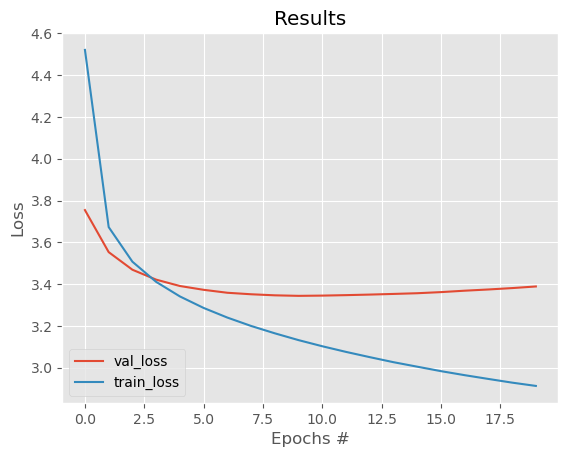

In [20]:
plt.style.use("ggplot")
plt.figure()
plt.plot(val_loss, label="val_loss")
plt.plot(training_loss, label="train_loss")
plt.title("Results")
plt.xlabel("Epochs #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("plot.png")
plt.show()


# ***Generate***

In [4]:
model_path = "gpt-model-architecture/GPT-model"
model = load_model(model_path)

def generate(prompt,tokenizer_obj,max_new_tokens=10,block_size=8):
    
#         code =  np.array(tokenizer_obj.encode(prompt))

        code =  np.array(tokenizer_obj.encode(prompt))
        code = code[: block_size].reshape(1,block_size)
        sequence = tf.convert_to_tensor(code,dtype=tf.int64)
        real_sequence = sequence
        for _ in range(max_new_tokens):
            sequence = sequence[:, -block_size:]
            # get the predictions
            pred = model(sequence)
            # focus only on the last time step
            pred = pred[:, -1, :] 
            # apply softmax to get probabilities
            probs = tf.nn.softmax(pred, axis=-1) 
            # sample from the distribution
#             next_token = tf.random.categorical(probs, num_samples=1, dtype=tf.int64) 
            next_token = tf.argmax(probs, axis=-1, output_type=tf.int64)  # (B,)
            next_token = tf.expand_dims(next_token, axis=-1)  # (B, 1)
            # append sampled index to the running sequence
            sequence = tf.concat([sequence, next_token], axis=1) 
            real_sequence = tf.concat([real_sequence, next_token], axis=1) 
            
        result = np.array(real_sequence[0]).tolist()
#         result = np.array(sequence[0]).tolist()
    
        if FRENCH :     
            return tokenizer_obj.decode(result).replace('<nl>',' ')
        return tokenizer_obj.decode(result)

In [6]:
TALK = False

start_prompt= "Mesdames Messieurs," if FRENCH else "Hey krimsGPT, how are you ?"
if RAP :
    start_prompt="'Noir c'est noir', ont-ils dit, y a donc vraiment plus d'espoir"
    
max_token = 200

if TALK : 
    while TALK : 
        prompt = input("User : ")
        prompt = prompt.replace("\n","<nl>")
        if prompt == "q":
            TALK = False
        else :
            start_prompt += prompt
            result = generate(start_prompt,tokenizer,max_token,BLOCK_SIZE)
            result = result.replace("<nl>","\n")
            print(f"KrimsGPT : {result}")
else :
    result = generate(start_prompt,tokenizer,max_token,BLOCK_SIZE)
    result = result.replace("<nl>","\n")
    print(f"User : {start_prompt}")
    print(f"KrimsGPT : {result}")

KeyboardInterrupt: Interrupted by user